In [1]:
# Notebook to compare basic meteorological parameters between WRF simulations and ERA5 data
# Some of the following imports are not used right now, but will retain for future flexibility
#import sys
#!{sys.executable} -m pip install geopandas
 
import os
import geopandas as gpd
from shapely.geometry import Point
from shapely.prepared import prep
import csv
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib.font_manager import FontProperties
import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata
from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
titles = ['Stage IV', 'Thompson', 'Thompson AA', 'WSM6', 'WDM6',
          'P3', 'P3 2X', 'P3 2nd', 'P3 3-mom', 'Ishmael', 'NTU']


In [3]:
# Load current file
wrf_file = "/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d02_2017-01-09_12:00:00"
datafiles = (glob.glob(wrf_file))
ncfile = Dataset(datafiles[0])
#lu_index = ncfile['LU_INDEX'][0,:,:]
#print(lu_index)
rainc = getvar(ncfile, "RAINC")
wrf_lats, wrf_lons = latlon_coords(rainc)
## WWRF longitude fix ######
new_lons =np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)

cart_proj = get_cartopy(rainc)

In [4]:
directory_path = '/scratch/sawyer/stage_IV_storm_tot/2017-01-09/72h_total'

all_files = os.listdir(directory_path)
stageiv_storm_total = np.zeros((881, 1121))
for file in all_files:
    file_path = os.path.join(directory_path, file)
    
    with pygrib.open(file_path) as grb:
        # Assuming the first message contains the precipitation data
        # Adjust as necessary based on the structure of your GRIB files
        message = grb.message(1)
        #print(message)
        data = message.values
        #print(data.shape)
        # Extract latitudes and longitudes
        stageiv_lats, stageiv_lons = message.latlons()

        stageiv_storm_total += data
# Use np.where to replace values greater than 1000 with 0
stageiv_storm_total = np.where(stageiv_storm_total > 1000, np.nan, stageiv_storm_total)
print(np.nanmax(stageiv_storm_total))

336.78999999999996


Text(0.5, 1.0, 'Stage IV 72 h Storm Total')

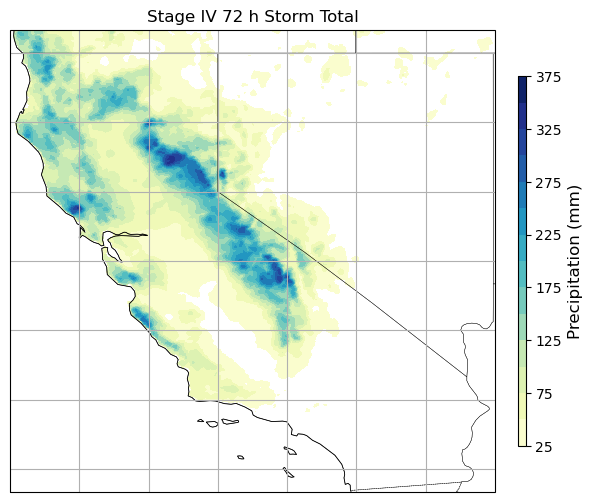

In [5]:

# Set limits for latitude and longitude to focus on California
# Rough bounds: (32.5 to 42 N) and (-124.5 to -114 W)
lon_min, lon_max = -124.5, -114
lat_min, lat_max = 32.5, 42.5

fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False # suppress top labels
gl.bottom_labels=False
gl.right_labels=False 
gl.left_labels=False

contours = plt.contourf(to_np(stageiv_lons), to_np(stageiv_lats), to_np(stageiv_storm_total), cmap='YlGnBu', levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
cbar = plt.colorbar(contours, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
cbar.set_label("Precipitation (mm)", fontsize = 12)
ax.set_title("Stage IV 72 h Storm Total")


In [6]:
def compute_rain_total(current_file_path, initial_file_path):
    # Load current file
    
    current_datafiles = (glob.glob(current_file_path))
    ncfile_current = Dataset(current_datafiles[0])
    land_mask = ncfile_current['LANDMASK'][0,:,:]
    

    rainc_current = getvar(ncfile_current, "RAINC")
    rainnc_current = getvar(ncfile_current, "RAINNC")
    rain_final = (rainnc_current + rainc_current) * land_mask
    # Apply the land mask on rain data
  
    # Load initial file
    initial_datafiles = (glob.glob(initial_file_path))
    ncfile_initial = Dataset(initial_datafiles[0])
    rainc_initial = getvar(ncfile_initial, "RAINC")
    rainnc_initial = getvar(ncfile_initial, "RAINNC")
    rain_initial = (rainnc_initial + rainc_initial) * land_mask
    # Apply the land mask on rain data
 
    
    return rain_final - rain_initial

def rmse(predictions, targets):
    x = (predictions - targets) ** 2
    x_mean = np.nanmean(x)
    rmserror = np.sqrt(x_mean)
    return rmserror

In [7]:
thompson_final = "/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d02_2017-01-09_12:00:00"
thompson_init = "/scratch/sawyer/wwrf/2017-01-09/ctrl/wrfout_d02_2017-01-06_12:00:00"

wsm6_final = "/scratch/sawyer/wwrf/2017-01-09/wsm6/wrfout_d02_2017-01-09_12:00:00"
wsm6_init = "/scratch/sawyer/wwrf/2017-01-09/wsm6/wrfout_d02_2017-01-06_12:00:00"

wdm6_final = "/scratch/sawyer/wwrf/2017-01-09/wdm6/wrfout_d02_2017-01-09_12:00:00"
wdm6_init = "/scratch/sawyer/wwrf/2017-01-09/wdm6/wrfout_d02_2017-01-06_12:00:00"

ishmael_final = "/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d02_2017-01-09_12:00:00"
ishmael_init = "/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d02_2017-01-06_12:00:00"

p3_final = "/scratch/sawyer/wwrf/2017-01-09/p3_1-cat/wrfout_d02_2017-01-09_12:00:00"
p3_init = "/scratch/sawyer/wwrf/2017-01-09/p3_1-cat/wrfout_d02_2017-01-06_12:00:00"

p3_2x_final = "/scratch/sawyer/wwrf/2017-01-09/p3_2x_cloud/wrfout_d02_2017-01-09_12:00:00"
p3_2x_init = "/scratch/sawyer/wwrf/2017-01-09/p3_2x_cloud/wrfout_d02_2017-01-06_12:00:00"

p3_3mom_final = "/scratch/sawyer/wwrf/2017-01-09/p3_3mom/wrfout_d02_2017-01-09_12:00:00"
p3_3mom_init = "/scratch/sawyer/wwrf/2017-01-09/p3_3mom/wrfout_d02_2017-01-06_12:00:00"

p3_2nd_final = "/scratch/sawyer/wwrf/2017-01-09/p3_2nd/wrfout_d02_2017-01-09_12:00:00"
p3_2nd_init = "/scratch/sawyer/wwrf/2017-01-09/p3_2nd/wrfout_d02_2017-01-06_12:00:00"

thompson_aa_final = "/scratch/sawyer/wwrf/2017-01-09/thompson_aa_38/wrfout_d02_2017-01-09_12:00:00"
thompson_aa_init = "/scratch/sawyer/wwrf/2017-01-09/thompson_aa_38/wrfout_d02_2017-01-06_12:00:00"

ntu_final = "/scratch/sawyer/wwrf/2017-01-09/ntu/wrfout_d02_2017-01-09_12:00:00"
ntu_init = "/scratch/sawyer/wwrf/2017-01-09/ntu/wrfout_d02_2017-01-06_12:00:00"

In [8]:
thompson_storm_total = compute_rain_total(thompson_final,thompson_init)

thompson_aa_storm_total = compute_rain_total(thompson_aa_final,thompson_aa_init)

wsm6_storm_total = compute_rain_total(wsm6_final,wsm6_init)

wdm6_storm_total = compute_rain_total(wdm6_final,wdm6_init)

p3_storm_total = compute_rain_total(p3_final,p3_init)

p3_2x_storm_total = compute_rain_total(p3_2x_final,p3_2x_init)

p3_2nd_storm_total = compute_rain_total(p3_2nd_final,p3_2nd_init)

p3_3mom_storm_total = compute_rain_total(p3_3mom_final,p3_3mom_init)

ishamel_storm_total = compute_rain_total(ishmael_final,ishmael_init)

ntu_storm_total = compute_rain_total(ntu_final,ntu_init)
#print(thompson_storm_total.shape)

In [9]:
wrf_totals = [thompson_storm_total,thompson_aa_storm_total,wsm6_storm_total,
            wdm6_storm_total,p3_storm_total,p3_2x_storm_total,p3_2nd_storm_total,
           p3_3mom_storm_total,ishamel_storm_total, ntu_storm_total]

In [10]:
# appending all the interpolated storm total 3 km wrf grids to a list with PRISM storm total
interp_list = [stageiv_storm_total]

for i in wrf_totals:
    # Define the source CRS (your PRISM data's original projection)
    target_proj = pyproj.Proj(proj='latlong', datum='WGS84')

    # Define the target CRS as WGS 84
    source_proj = pyproj.Proj(proj="latlong", datum="WGS84")

    # Transform the WRF coordinates
    lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats)
    #print(lon_new)

    # Assuming wrf_lon and wrf_lat are the 2D arrays representing the longitude and latitude grids of your WRF data.
    points_wrf = (lon_new.ravel(), lat_new.ravel()) 
    #print(points_prism)# Reprojected PRISM coordinates
    values_wrf = to_np(i).ravel()  # PRISM data values

    data_wrf = griddata(points_wrf, values_wrf, (stageiv_lons,stageiv_lats), method='linear')
    interp_list.append(data_wrf)

/tmp/ipykernel_52602/3768043142.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats)
/tmp/ipykernel_52602/3768043142.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats)
/tmp/ipykernel_52602/3768043142.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(source_proj, target_proj, new_lons,wrf_lats)
/tmp/ipykernel_52602/3768043142.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(sourc

Text(0.5, 1.0, 'Stage IV 72 h Storm Total')

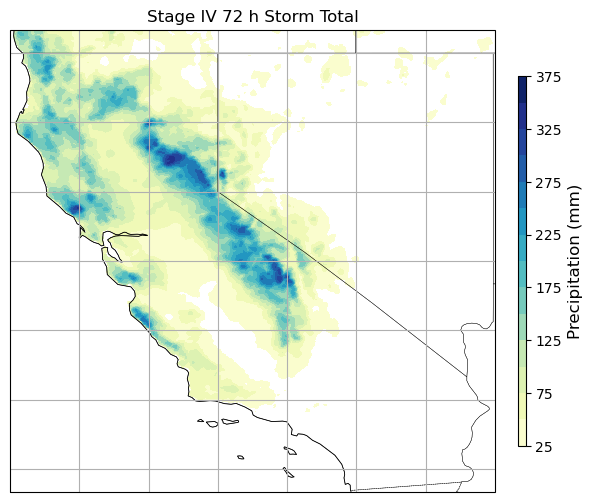

In [11]:
stageiv_data = interp_list[0]
#wrf_data = interp_list[1:]
#print(stageiv_data[stageiv_data<89991])

# Set limits for latitude and longitude to focus on California
# Rough bounds: (32.5 to 42 N) and (-124.5 to -114 W)
lon_min, lon_max = -124.5, -114
lat_min, lat_max = 32.5, 42.5

fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='black')
ax.coastlines('50m', linewidth=0.6, color='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False # suppress top labels
gl.bottom_labels=False
gl.right_labels=False 
gl.left_labels=False

contours = plt.contourf(to_np(stageiv_lons), to_np(stageiv_lats), to_np(stageiv_data), cmap='YlGnBu', levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
cbar = plt.colorbar(contours, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
cbar.set_label("Precipitation (mm)", fontsize = 12)
ax.set_title("Stage IV 72 h Storm Total")

In [12]:
# Load US states shapefile
states = gpd.read_file('/scratch/sawyer/geopandas/ne_110m_admin_1_states_provinces.shp')

# Get combined shape of California and Nevada
combined_shape = states[states.name.isin(['California', 'Nevada'])].unary_union
prepared_shape = prep(combined_shape)  # Prepare the geometry for faster operations

def in_combined_shape(lats, lons):
    """Check if coordinates are inside the combined shape of California and Nevada."""
    point = Point(lons, lats)
    return prepared_shape.contains(point)

# Vectorize the function
vectorized_contains = np.vectorize(in_combined_shape)

# Assuming stageiv_lons and stageiv_lats are 1D arrays or flattened arrays
ca_nv_stageiv = vectorized_contains(stageiv_lats,stageiv_lons)

In [13]:
ca_nv_data = []

for precip_value in interp_list:
     # now placing the California mask over the new Stage IV data
    state_mask = np.where(ca_nv_stageiv, precip_value, np.nan)
    ca_nv_data.append(state_mask)

/tmp/ipykernel_52602/3217854121.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


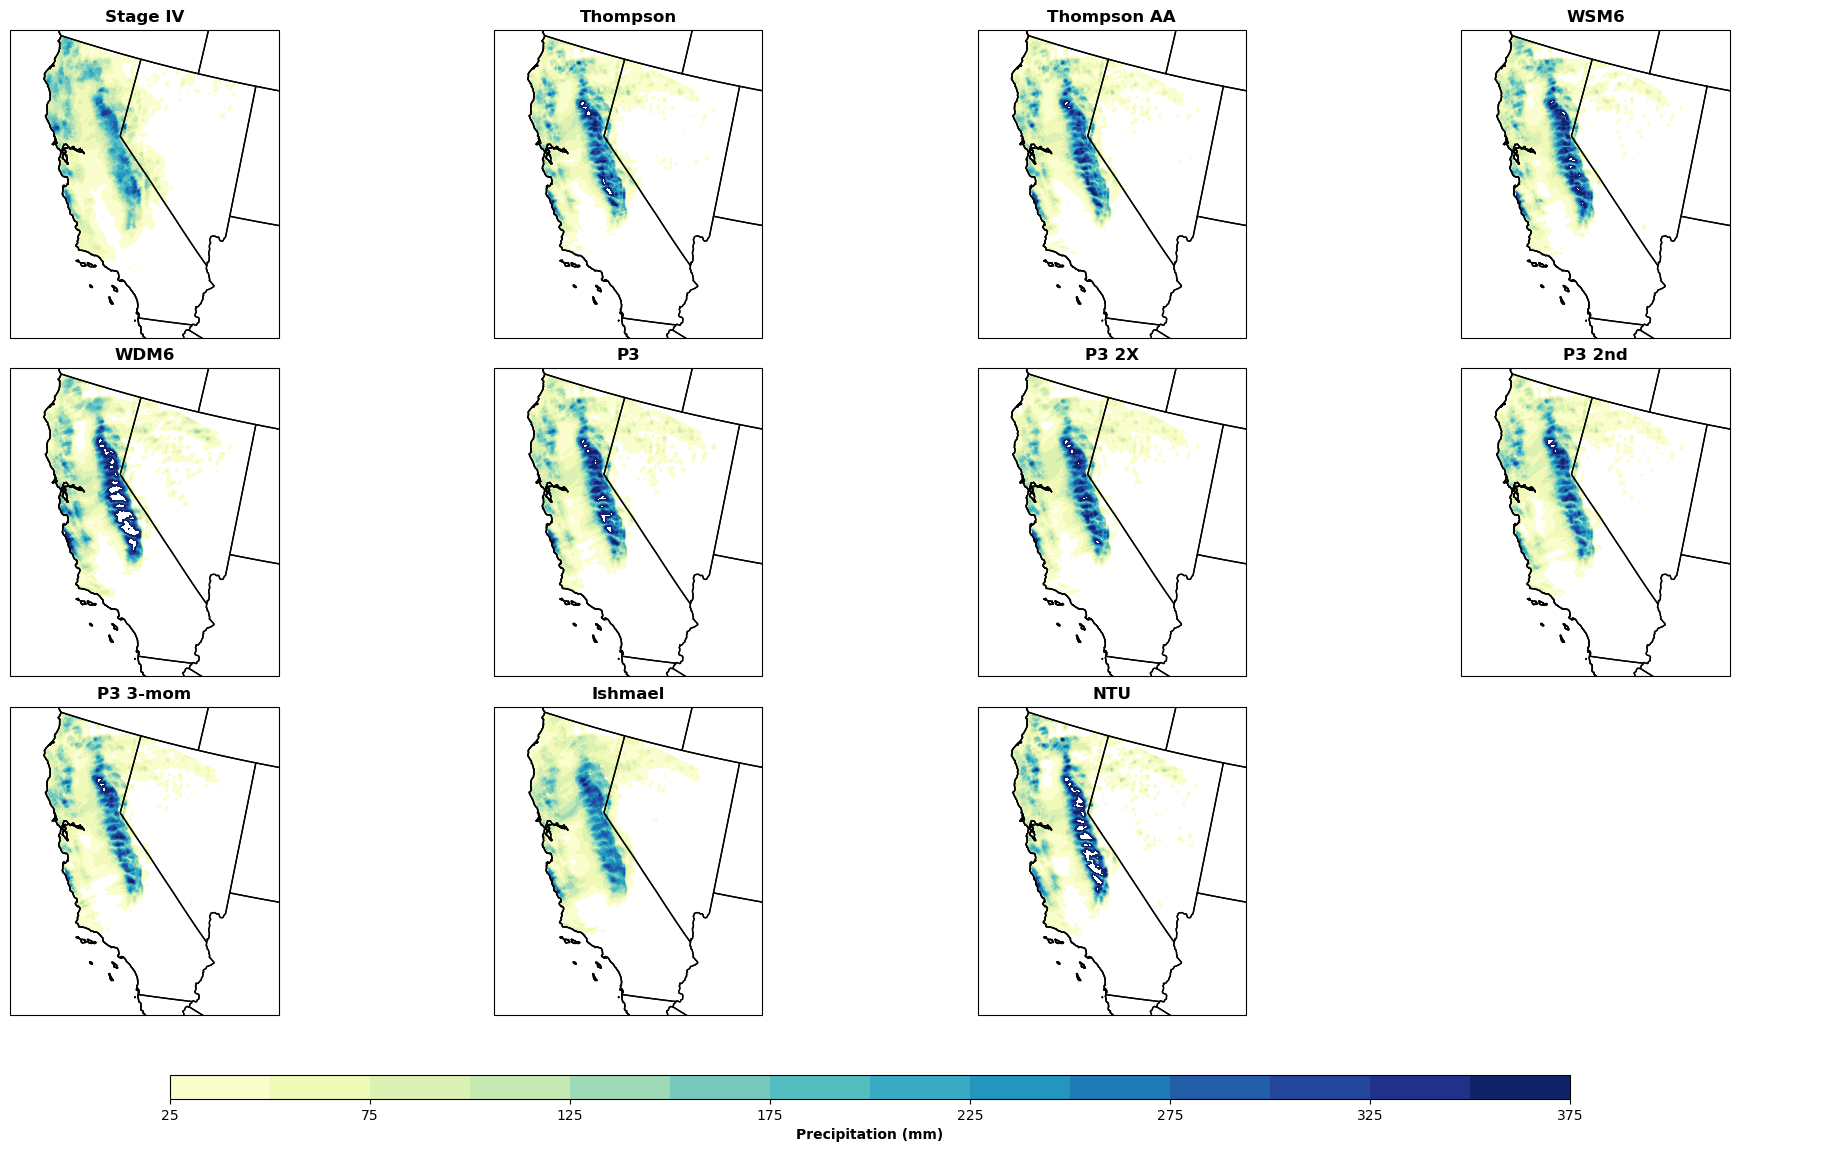

In [14]:
font_bold = FontProperties()
font_bold.set_weight('bold')
# Create 10 subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12),
                        subplot_kw={'projection': ccrs.LambertConformal()}) #ccrs.PlateCarree()
axs = axs.ravel()  # Flatten axs to loop over
# Gridlines' latitudes and longitudes
lats = np.arange(32.5, 43, 2)  # Example: ticks every 2 degrees. Adjust as needed.
lons = np.arange(-125, -114, 2)
for i, ax in enumerate(axs[:-1]):
    #print(titles[i])
    ax.set_extent([-123,-113,32.5,42.5])
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black')  # Add coastlines
    ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor='black')
    # Use gridlines and customize them to look like ticks
    #gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.5, linestyle='--', xlocs=lons, ylocs=lats)
    #gl.xlabels_bottom = True
    #gl.ylabels_left = True
    #gl.xlines = True
    #gl.ylines = True
    #gl.linewidth = .5
    #gl.color = 'black'

    # Set the title for each subplot
    ax.set_title(titles[i], fontweight='bold')
    # Plot filled contour
    cp = ax.contourf(to_np(stageiv_lons),to_np(stageiv_lats), to_np(ca_nv_data[i]), cmap='YlGnBu', 
                     levels=np.arange(25, 400, 25), transform=ccrs.PlateCarree())
    ax.coastlines()
# Turn off the last subplot
axs[-1].axis('off')
# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal', label="Precipitation (mm)")
cbar.set_label("Precipitation (mm)", fontproperties=font_bold)
# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar

plt.savefig('StormTotal_QPF_StageIV')
plt.show()

In [15]:
stageiv = ca_nv_data[0]
diff_fields = []
for precip_value in ca_nv_data[1:]:
    # Compute the difference
    diff_fields.append(stageiv - precip_value)
    
print(len(diff_fields))#[0].shape)

#for i in diff_fields:
    

10


In [16]:
stageiv_sum = np.nanmean(stageiv)
print(stageiv_sum)
bias_errors = []
for precip_data in ca_nv_data[1:]:
    
    total = np.nanmean(precip_data)
    bias = round((total-stageiv_sum),2)
    bias_errors.append(bias)
    #print(total)
    #print('bias: ', bias)

42.81131603472801


In [17]:

#mse = mean_squared_error(data_wrf, thompson_storm_total)
#rmsee = np.sqrt(mse)

rain_errors = []
for precip_data in ca_nv_data[1:]:
    errors = rmse(precip_data,stageiv)
    rain_errors.append(round(errors,2))
    
wrf_titles = ['Thompson', 'Thompson AA', 'WSM6', 'WDM6',
          'P3', 'P3 2X', 'P3 2nd', 'P3 3-mom', 'Ishmael', 'NTU']


In [18]:
print(rain_errors)

[32.08, 31.93, 34.52, 51.09, 35.62, 36.28, 32.57, 30.86, 31.22, 48.98]


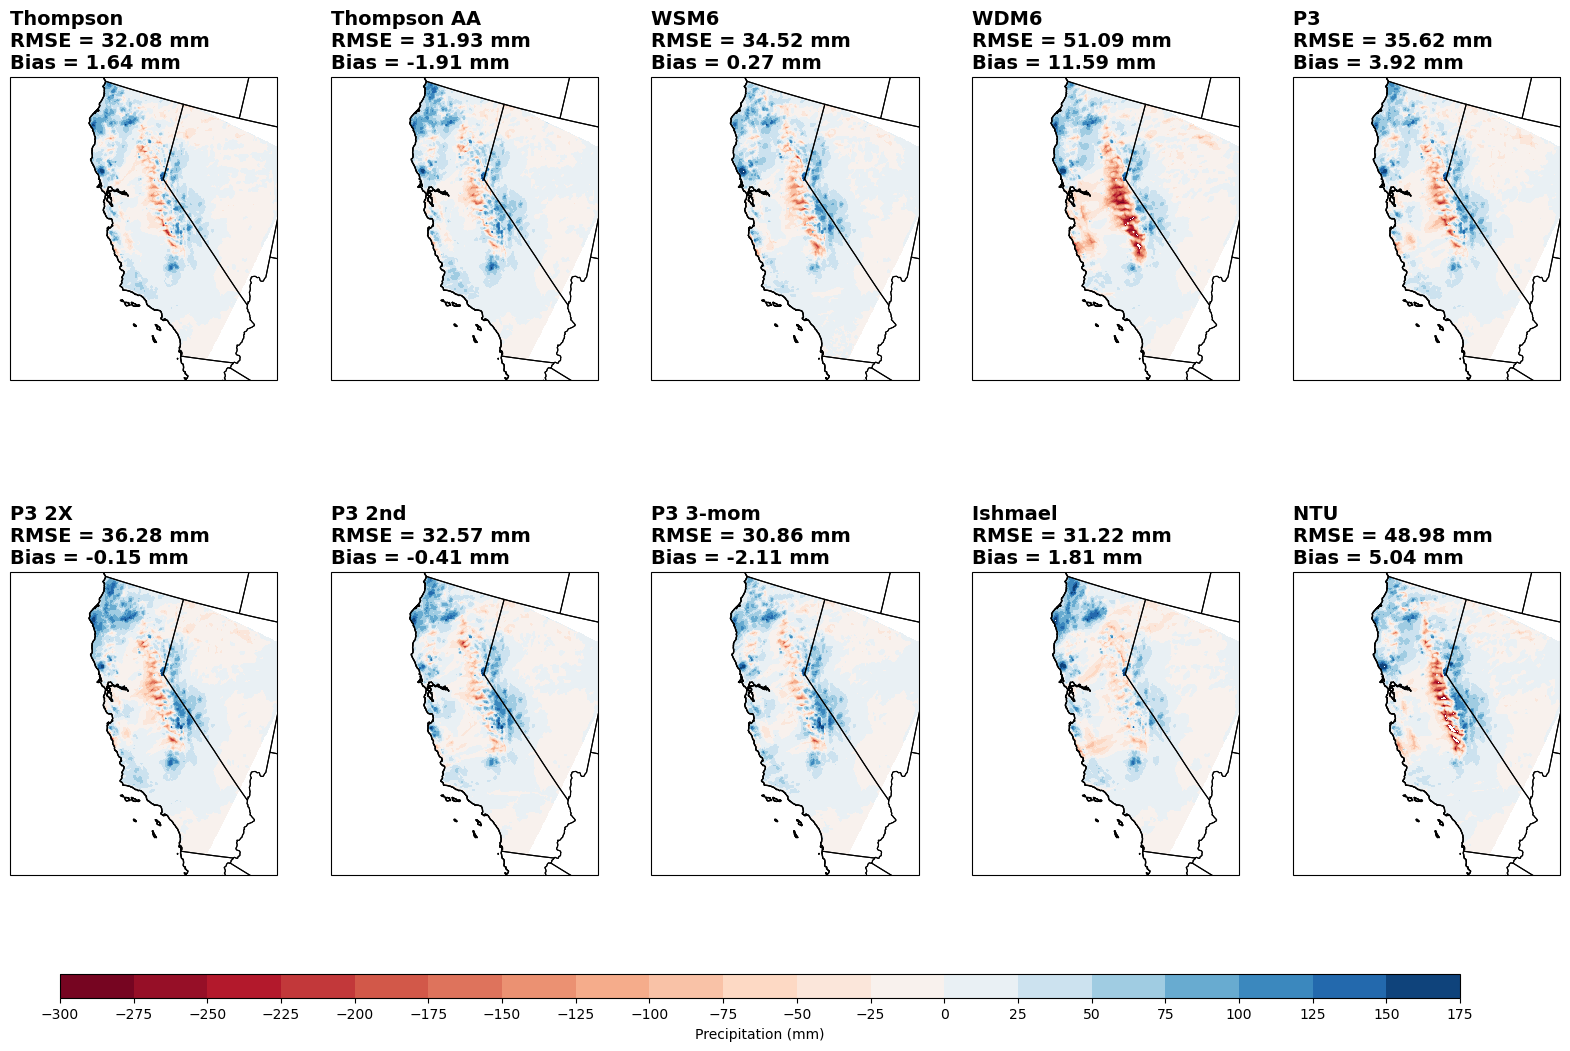

In [19]:
# Create 10 subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 12),
                        subplot_kw={'projection': ccrs.LambertConformal()})
axs = axs.ravel()  # Flatten axs to loop over
# Gridlines' latitudes and longitudes
lats = np.arange(32, 43, 2)  # Example: ticks every 2 degrees. Adjust as needed.
lons = np.arange(-125, -114, 2)
#levels = np.arange(-200,200,50)
levels = np.arange(-300, 200, 25)

norm = TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())  # This normalizes the colormap around 0
for i, ax in enumerate(axs):
    #print(titles[i])
    ax.set_extent([-125,-115,32,42])
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')  # Add coastlines
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    # Use gridlines and customize them to look like ticks
    #gl = ax.gridlines(draw_labels=False, linewidth=1, color='black', alpha=0.5, linestyle='--', xlocs=lons, ylocs=lats)
    #gl.xlabels_bottom = True
    #gl.ylabels_left = True
    #gl.xlines = True
    #gl.ylines = True
    #gl.linewidth = .5
    #gl.color = 'black'

    # Set the title for each subplot
    ax.set_title(f"{wrf_titles[i]} \nRMSE = {rain_errors[i]} mm\nBias = {bias_errors[i]} mm", fontweight='bold', fontsize=14,loc='left')
    #ax.set_title(f"RMSE = {rain_errors[i]} mm", fontweight='bold',fontsize=10, loc='right')
    # Plot filled contour
    cp = ax.contourf(to_np(stageiv_lons),to_np(stageiv_lats), diff_fields[i],levels=levels, cmap='RdBu', norm=norm,transform=ccrs.PlateCarree())
    ax.coastlines()
    

# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cp, cax=cbar_ax, orientation='horizontal', label="Precipitation (mm)")
# Set the ticks explicitly
cbar.set_ticks(levels)
#cbar.set_label(fontproperties=font_bold)
# Adjust layout
#fig.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.3)  # Make space for the colorbar

plt.savefig('Staveiv_StormTotal_Diff_Fields_QPF')
plt.show()

In [25]:
from scipy.stats import pearsonr

wrf_data = to_np(ca_nv_data[1:])
wrf = np.nan_to_num(wrf_data)
#valid_indices = ~np.isnan(prism) & ~np.isnan(wrf)
corr = []
corr_sqrd = []
for i in wrf:
    # Calculate valid indices for the current pair
    valid_indices = ~np.isnan(stageiv) & ~np.isnan(i)
    
    correlation_coefficient, _ = pearsonr(i[valid_indices], stageiv[valid_indices])
    corr_sq = correlation_coefficient**2
    corr_sqrd.append(round(corr_sq,4))
    correlation_coefficient = round(correlation_coefficient,4)
    #print(correlation_coefficient)
    corr.append(correlation_coefficient)
print(corr_sqrd)

[0.7774, 0.7611, 0.7601, 0.7099, 0.7546, 0.7192, 0.7484, 0.7709, 0.7593, 0.6805]


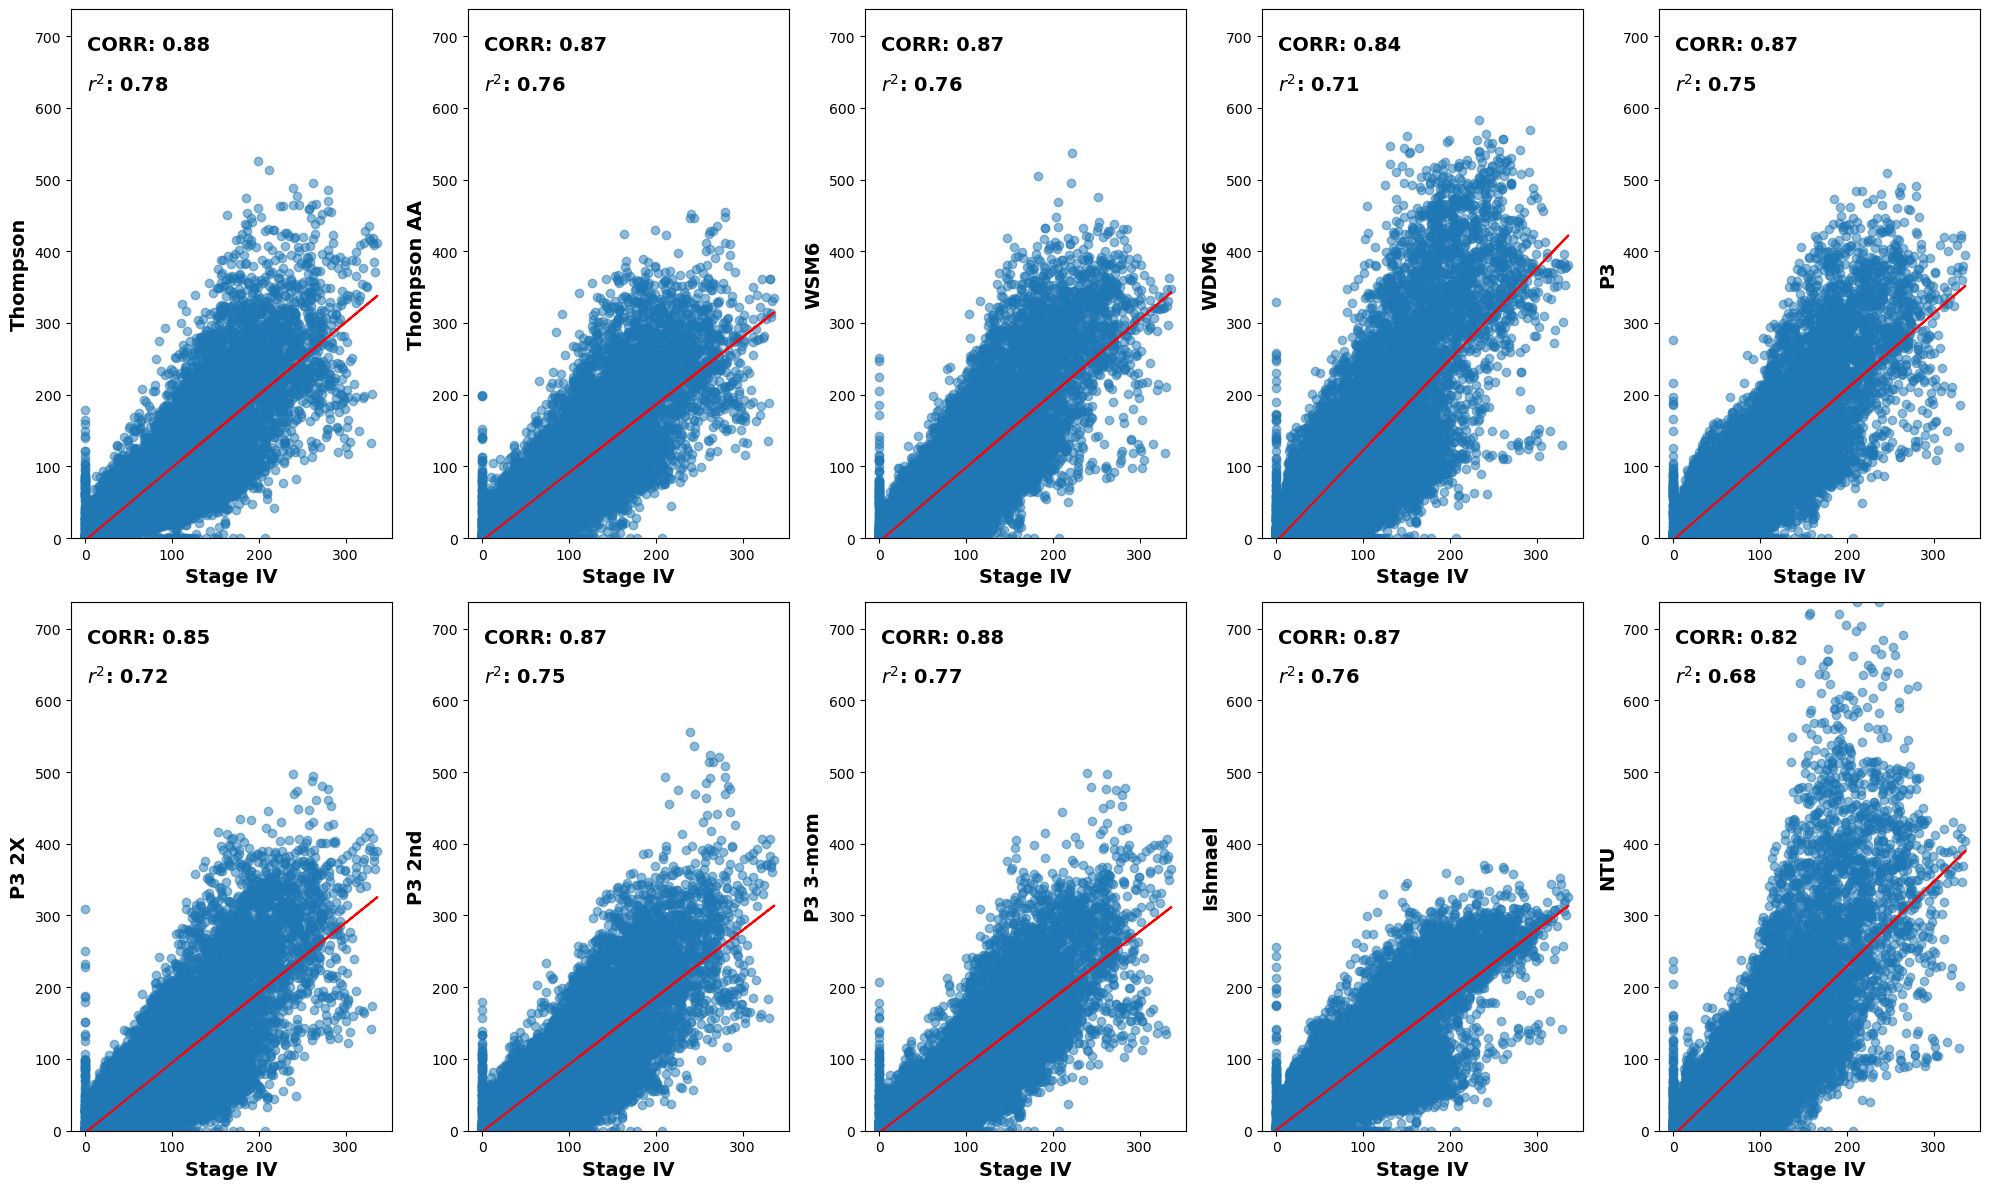

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 12))
axs = axs.ravel()

corr = []
corr_sqrd = []
# Determine global min and max for y-axis
global_min = np.nanmin([np.nanmin(data) for data in wrf])
global_max = np.nanmax([np.nanmax(data) for data in wrf])
for i, ax in enumerate(axs):
    current_wrf_data = wrf[i]
    
    valid_indices = ~np.isnan(stageiv) & ~np.isnan(current_wrf_data)
    filtered_prism = np.array(stageiv)[valid_indices]
    filtered_wrf_data = np.array(current_wrf_data)[valid_indices]
    ax.set_ylim(global_min, global_max)
    # Scatter plot
    ax.scatter(filtered_prism, filtered_wrf_data, alpha=0.5, label='Data')

    # Line of best fit
    slope, intercept = np.polyfit(filtered_prism, filtered_wrf_data, 1)
    ax.plot(filtered_prism, slope*filtered_prism + intercept, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(filtered_prism, filtered_wrf_data)
    corr.append(correlation_coefficient)
    corr_sqrd.append(correlation_coefficient**2)
    
    # Add legend entry for correlation coefficient and r^2
    #ax.legend([f'Corr: {correlation_coefficient:.2f}', f'$r^2$: {correlation_coefficient**2:.2f}'])
    #ax.legend([f'Corr: {correlation_coefficient:.2f}', f'$r^2$: {correlation_coefficient**2:.2f}'], fontsize=13,loc='upper left')
    # Add text for correlation coefficient and r^2 in the upper left corner
    ax.text(0.05, 0.95, f'CORR: {correlation_coefficient:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=14,fontweight='bold')
    ax.text(0.05, 0.88, f'$r^2$: {correlation_coefficient**2:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=14,fontweight='bold')
   # Add labels 
    ax.set_xlabel('Stage IV', fontsize = 14,fontweight='bold')
    ax.set_ylabel(f'{wrf_titles[i]}', fontsize = 14,fontweight='bold')

plt.tight_layout()
plt.savefig('Stageiv_QPF_CORR')
plt.show()

In [28]:
zero_count = np.sum(filtered_prism == 0)
print(zero_count)

6285


In [30]:
zero_count = np.sum(filtered_wrf_data == 0)
print(zero_count)

5580
